## La Palma Eruption Figures and Analysis

#### Figures
1. top down kriging map on la palma photogrammetry
2. distance from launch & altitude kriging map
4. Highlight good gaussian fit (fig 3) next to all data combined (fig 7) - in context of all of the data (all combined) - divide into days, maybe add color to elevation

In [34]:
%matplotlib inline

import os, sys, math, datetime, time
import rasterio
import numpy
from rasterio.plot import show
from scipy.optimize import curve_fit
import datetime as dt
from matplotlib import pyplot as plt
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
})

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

from dragonfly_util.logtocsv import parse_log
from dragonfly_util.plot_util import *

In [35]:
la_palma_map_original = rasterio.open("la_palma_map4.tif")
la_palma_map = rasterio.open("la_palma_map4b.tif")

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [36]:
def gaussian(amplitude, x, y, xmean, ymean, xstd_dev, ystd_dev):
    return amplitude * \
        (np.exp(- (((x - xmean) / xstd_dev) ** 2) / 2) / (xstd_dev * math.sqrt(2 * math.pi))) * \
        (np.exp(- (((y - ymean) / ystd_dev) ** 2) / 2) / (ystd_dev * math.sqrt(2 * math.pi)))

def gaussian_slice(amplitude, x, mean, std_dev):
    return gaussian(amplitude, x, 0, mean, 0, std_dev, std_dev)

def difference(distance_data, amplitude, mean, std_dev, ambient):
    difference_sum = 0
    for i in range(len(distance_data)) :
        if distance_data[i]["value"] > ambient:
            calculated_value = gaussian_slice(amplitude, distance_data[i]["distance"], mean, std_dev)
            calculated_difference = distance_data[i]["value"] - ambient
            difference = calculated_value - calculated_difference
            difference_sum = difference_sum + (difference ** 2)
    return difference_sum

def fit_data(distance_data, ambient, mean, std_dev, current, learning_rate, max_iter, precision=0.0000001):

    above_ambient_distance_data = [d for d in distance_data if d["value"] > ambient]
    x_values = [d["distance"] for d in above_ambient_distance_data]
    y_values = [d["value"] - ambient for d in above_ambient_distance_data]

    def gaussian(x, amplitude):
        return gaussian_slice(amplitude, x, mean, std_dev)

    params, covariance = curve_fit(gaussian, x_values, y_values, ftol=precision, p0=[current])

    a_fit = params[0]

    return a_fit, difference(distance_data, a_fit, mean, std_dev, ambient)


def flux(C):
    wind_speed = 10 # m/s
    seconds_in_day = 60 * 60 * 24 # s / day
    tonnes_per_g = math.pow(10, -6) # tonnes / g
    kg_per_g = math.pow(10, -3) # kg / g
    CO2_molecular_weight = 44.01 # g / mol
    l_per_m3 = 1000 # l / m3
    moles_per_m3 = l_per_m3 / 22.80 # mol / m3
    moles_per_liter = 1 / 22.80 # mol / l
    # g / mol * mol / l = g / l = g / 1000 m^3 = mg / m^3
    # (ppm m2)* (g / mol) * (mol / l) * (m/s) * (tonnes / g) * (s / day)
    # g CO2 m2 / m3 * (m/s) * (tonnes / g) * (s / day)
    # tonnes CO2 / day
    return C * CO2_molecular_weight * moles_per_liter / l_per_m3 * wind_speed * tonnes_per_g * seconds_in_day
#     return C * CO2_molecular_weight * moles_per_liter / l_per_m3 * wind_speed * kg_per_g

def area(distance_data, ambient):
        
    area_sum = 0
    size = len(distance_data)
    for i in range(size):
        if distance_data[i]["value"] > ambient:
            left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
            right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
            area_sum += (distance_data[i]["value"] - ambient) * abs(right - left)

    return area_sum

def render_scatter_areas(ax, distance_data, ambient):

    size = len(distance_data)
    for i in range(size):
        if distance_data[i]["value"] > ambient:
            left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
            right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
            ax.add_patch(Rectangle((left, ambient), right - left, distance_data[i]["value"] - ambient, color='lightsteelblue'))

EARTH_CIRCUMFERENCE = 40008000

def render_distance_data(starting_position, data, ambient, date, transect, plume, altitude, ax, min_distance=0, limit_distance=None, legend=True, use_max=False, plot_gaussian=True, max_co2=700, angle=math.pi/2, delegate=None):
    total = 0
    count = 0
    
    distance_data = []
    max_distance = 0
    distance_angle_scale = math.sin(angle)
    
    for d in data:
        lat_diff = (starting_position.lat - d.lat) * (EARTH_CIRCUMFERENCE / 360)
        distance = lat_diff * distance_angle_scale
        if distance > min_distance:
            distance_data.append({"distance": distance, "value": d.value})
            if(distance > max_distance):
                max_distance = distance
            
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            total = total + (relative_co2 * distance_data[i]["distance"])
            count = count + relative_co2
        
    mean = max_distance if use_max else total / count
    
    std_total = 0
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            distance_diff = distance_data[i]["distance"] - mean
            std_total = std_total + (relative_co2 * (distance_diff * distance_diff))
    m = len(distance_data)
    
    std_dev = math.sqrt(std_total / (((m-1) / m) * count))

    [minimum_s, minimum_x2] = fit_data(distance_data, ambient, mean, std_dev, 4500, 100, 1000)
    
    scatter_area = area(distance_data, ambient)
    
#     print("{} m: {:.2f} sd: {:.2f} a: {:.2f} x2: {:.2f} flux: {:.2f} t/day".
#           format(title, minimum_s, mean, std_dev, minimum_x2, flux(minimum_s)))

    def sci_format(input):
        # Convert the number to scientific notation
        exponent = 0
        while abs(input) >= 10:
            input /= 10
            exponent += 1
        while abs(input) < 1:
            input *= 10
            exponent -= 1
        return f"{input:.2f}\\times10^{exponent}"

    title = f"{transect} Plume {plume}"
    print(f"{date} & {title} & {altitude} m & ${sci_format(minimum_s)}$ & ${sci_format(minimum_x2)}$ & ${sci_format(flux(minimum_s))}$")
        
    x = np.linspace(mean - 5*std_dev, mean + 5*std_dev, 100)
    pdf = [(x) + ambient for x in gaussian_slice(minimum_s, x, mean, std_dev)]
    
    if delegate is not None:
        delegate(ax)
    
    ax.title.set_text(f"Transect {transect} Plume {plume}")
    render_scatter_areas(ax, distance_data, ambient)
    ax.scatter([d["distance"] for d in distance_data], [d["value"] for d in distance_data], s=1, label="CO$_2$ readings")
    if plot_gaussian:
        ax.plot(x, pdf, c='r', label='Gaussian fit x2:{:.2f} flux:{:.2f}t/day'.format(minimum_x2, flux(minimum_s)))
    ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Distance East from takeoff (m)')
    ax.set_ylabel('CO$_2$ Concentration(ppm)')
    if limit_distance is not None:
        ax.set_aspect('auto')
        ax.set_xlim(0, limit_distance * distance_angle_scale)
        
    ax.set_ylim(400, max_co2)
    if legend:
        ax.legend()
    ax.plot()

def saveFigure(plt, name, dpi=72):
    figure_path = 'figures'
    if not os.path.exists(figure_path):
       os.makedirs(figure_path)
    plt.savefig(figure_path + "/" + name + ".pdf", format="pdf", dpi=dpi)
    plt.savefig(figure_path + "/" + name + ".png", format="png", dpi=dpi)
    
def display_data(name, readings, nlags=6):
    display_data_altitude(readings)
    
    display_readings(readings)

In [37]:
def read_data(file):
    return parse_log(file, skip_zeroing=False)

def filter_data(input, predicate):
    filtered = []
    for i in input:
        if predicate(i):
            filtered.append(i.data)
    return filtered

def between(start, end):
    start_date = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
    end_date = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
    return lambda value: value.type =='reading' and start_date <= value.date and end_date >= value.date and value.data.value > 0

def get_next_point(input, time):
    threshold_date = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f')
    for value in input:
        if value.time > threshold_date:
            return value
    return None


df3_data = read_data("la_palma_data/la palma 11-28-2021 - df3.log")
df4_data = read_data("la_palma_data/la palma 11-29-2021 - df4.log")

transect_1km_a = filter_data(df4_data, between('2021-11-26 12:31:27.020316', '2021-11-26 12:35:06.006446'))
transect_1km_b = filter_data(df4_data, between('2021-11-26 12:35:06.006446', '2021-11-26 12:40:31.575184'))
lapalma_flight1 = transect_1km_a + transect_1km_b
lapalma_flight2a = filter_data(df4_data, between('2021-11-26 12:48:30.019876', '2021-11-26 12:53:59.006718'))
lapalma_flight2b = filter_data(df4_data, between('2021-11-26 12:53:59.006718', '2021-11-26 12:58:59.005814'))
lapalma_flight3 = filter_data(df4_data, between('2021-11-27 10:04:25.135506', '2021-11-27 10:13:39.120506'))
lapalma_flight4 = filter_data(df3_data, between('2021-11-27 13:15:02.982099', '2021-11-27 13:27:34.548221'))
lapalma_flight5 = filter_data(df3_data, between('2021-11-27 16:05:08.784123', '2021-11-27 16:24:0.942152'))
first_plume = filter_data(df3_data, between('2021-11-27 16:06:00.0', '2021-11-27 16:08:00.0'))
curtain_plume = filter_data(df3_data, between('2021-11-27 16:07:50.0', '2021-11-27 16:12:20.0'))
returning_plume = filter_data(df3_data, between('2021-11-27 16:14:30.0', '2021-11-27 16:16:30.0'))
lapalma_flight6 = filter_data(df3_data, between('2021-11-28 12:29:14.86601', '2021-11-28 12:45:21.740369'))
lapalma_flight8 = filter_data(df4_data, between('2021-11-29 10:58:22.295029', '2021-11-29 11:05:33.152931'))

flight_list = [lapalma_flight1, 
               lapalma_flight2a, 
               lapalma_flight2b, 
               lapalma_flight3, 
               lapalma_flight4, 
               lapalma_flight5, 
               first_plume, 
               curtain_plume, 
               returning_plume, 
               lapalma_flight6, 
               lapalma_flight8]

flight_labels = ['flight 1', 'flight 2a', 'flight 2b', 'flight 3', 'flight 4', 'flight 5', 'fligh 6a', 'flight 6b', 'flight 6c', 'flight 6', 'flight 8']
all_data = [item for sublist in flight_list for item in sublist]

collection_point = get_next_point(lapalma_flight6, '2021-11-28 12:35:14.86601')

Warning 1: TIFFFetchNormalTag:Incompatible type for "GeoPixelScale"; tag ignored
Warning 1: TIFFFetchNormalTag:Incorrect value for "RichTIFFIPTC"; tag ignored
Warning 1: TIFFFetchNormalTag:Incompatible type for "GeoTiePoints"; tag ignored
Warning 1: TIFFFetchNormalTag:Incompatible type for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:Incompatible type for "GeoDoubleParams"; tag ignored
Warning 1: TIFFFetchNormalTag:Incompatible type for "GeoPixelScale"; tag ignored
Warning 1: TIFFFetchNormalTag:Incorrect value for "RichTIFFIPTC"; tag ignored
Warning 1: TIFFFetchNormalTag:Incompatible type for "GeoTiePoints"; tag ignored
Warning 1: TIFFFetchNormalTag:Incompatible type for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:Incompatible type for "GeoDoubleParams"; tag ignored
Warning 1: TIFFFetchNormalTag:Incompatible type for "GeoPixelScale"; tag ignored
Warning 1: TIFFFetchNormalTag:Incorrect value for "RichTIFFIPTC"; tag ignored
Warning 1: TIFFFetchNormalTag:I

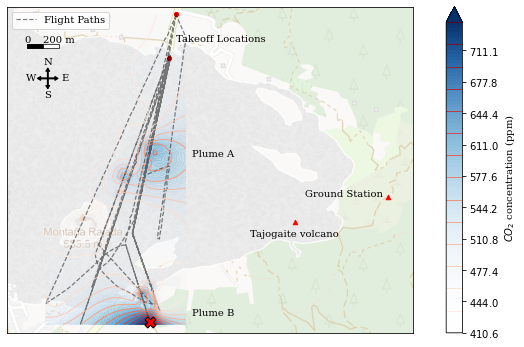

In [38]:
def zoom_to_data(ax, data):
    max_lat = -360
    min_lat = 360
    max_lon = -360
    min_lon = 360
    for d in data:
        max_lat = max(max_lat, d.lat)
        min_lat = min(min_lat, d.lat)
        max_lon = max(max_lon, d.lon)
        min_lon = min(min_lon, d.lon)

    dlat = max_lat - min_lat
    dlon = max_lon - min_lon
    lat_margin_scale = 0.2
    lon_margin_scale = 1.5
    minimum_size = 0.001

    dlat = max(max(dlat, dlon), minimum_size)
    dlon = max(dlat, dlon)

    ax.set_xlim(min_lon - (lon_margin_scale * dlon), max_lon + (lon_margin_scale * dlon))
    ax.set_ylim(min_lat - (lat_margin_scale * dlat), max_lat + (lat_margin_scale * dlat))
    print((min_lon - (lon_margin_scale * dlon)))
    print((max_lon + (lon_margin_scale * dlon)))
    print((min_lat - (lat_margin_scale * dlat)))
    print((max_lat + (lat_margin_scale * dlat)))
    
def add_compass(plt, ax) :
    
    unit = (plt.xlim()[1] - plt.xlim()[0]) * 0.05
    center = [plt.xlim()[0] + (plt.xlim()[1] - plt.xlim()[0]) *.1, 
             plt.ylim()[1] - (plt.ylim()[1] - plt.ylim()[0]) *.22]
    
    ax.arrow(center[0] - unit/2, center[1], unit, 0, head_width=unit * 0.2, head_length=unit * 0.15, width=unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0] + unit/2, center[1], -unit, 0, head_width=unit * 0.2, head_length=unit * 0.15, width=unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0], center[1] - unit/2, 0, unit, head_width=unit * 0.2, head_length=unit * 0.15, width=unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0], center[1] + unit/2, 0, -unit, head_width=unit * 0.2, head_length=unit * 0.15, width=unit * 0.03, length_includes_head=True, color='black')

    ax.annotate('N', xy=(center[0], center[1] + unit/1.2), ha='center', va='center')
    ax.annotate('E', xy=(center[0] + unit/1.2, center[1]), ha='center', va='center')
    ax.annotate('S', xy=(center[0], center[1] - unit/1.2), ha='center', va='center')
    ax.annotate('W', xy=(center[0] - unit/1.2, center[1]), ha='center', va='center')
    
    
def add_ruler2(plt, ax, length):
    height_scale = 0.7
    lowerleft = [plt.xlim()[0], plt.ylim()[0]]
    upperright = [plt.xlim()[1], plt.ylim()[1]]

    # Calculate width by latitide
    width = abs(1.0 * length / (EARTH_CIRCUMFERENCE / 360))
    height = (upperright[1] - lowerleft[1]) * 0.018 * height_scale

    location = [plt.xlim()[0] + (plt.xlim()[1] - plt.xlim()[0]) *.05,
                plt.ylim()[1] - ((plt.ylim()[1] - plt.ylim()[0]) *(.1 + (height_scale * .04)))]

    ax.add_patch(Rectangle(location, width, height, ec=(0,0,0,1), fc=(1,1,1,1), lw=height_scale))
    ax.add_patch(Rectangle(location, width/2, height, ec=(0,0,0,1), fc=(0,0,0,1), lw=height_scale))
    ax.annotate("0", xy=(location[0], location[1] + (1.5 * height)), ha='center')
    ax.annotate("{} m".format(length), xy=(location[0] + width, location[1] + (1.5 * height)), ha='center')
    

def display_readings_krige2(name, readings, flights, nlags=6, minco2=None, maxco2=None, addons=None):
    fig, ax = plt.subplots(figsize=(12, 6))

    show(la_palma_map.read(), ax=ax, transform=la_palma_map_original.transform, alpha=0.35)
    
    ax.plot([d.lon for d in flights], [d.lat for d in flights], color='k', linestyle='--', lw=1.2, alpha=0.5, label="Flight Paths")

    plot_krige(name, fig, ax, [r.lon for r in readings], [r.lat for r in readings], [r.value for r in readings], nlags, minco2, maxco2, paths_lons=[r.lon for r in flights], paths_lats=[r.lat for r in flights])

    ax.set_xlim(-17.883, -17.86)
    ax.set_ylim(28.6065, 28.625)
    
    geo_axis_format(ax)

    def marker_left(position, text, marker='^'):
        ax.scatter(position[0], position[1], s=20, color='r', marker=marker)
        ax.annotate(text, position, (position[0] - 0.00025, position[1] + 0.000), ha='right')
        
    def marker_center(position, text, marker='^'):
        ax.scatter(position[0], position[1], s=20, color='r', marker=marker)
        ax.annotate(text, position, (position[0], position[1] - 0.0008), ha='center')
        
    # Markers
    ax.annotate("Takeoff Locations", [-17.8737, 28.623], (-17.8737 + 0.00025, 28.623), ha='left')
    ax.scatter(-17.8738061, 28.6220798, s=20, color='r', marker='8')
    ax.scatter(-17.8734256, 28.6245778, s=20, color='r', marker='8')
    marker_left([-17.861408, 28.614214], "Ground Station")
    marker_center([-17.866684021210542, 28.61277150738451], "Tajogaite volcano")
    
    # Plumes
    ax.annotate("Plume A", [-17.8725, 28.6165])
    ax.annotate("Plume B", [-17.8725, 28.6075])
    
    ax.scatter(collection_point.lon, collection_point.lat, s=120, color='r', marker='X', zorder=2, edgecolors='black', linewidth=1)
    
    ax.legend(loc="upper left")
    
    add_ruler2(plt, ax, 200)
    add_compass(plt, ax)
    
    if addons is not None:
        addons(plt, fig, ax)

    ax.plot()
    
combined_data = [item for item in all_data if item.value > 430]
limited_all_data = [item for item in all_data if item.lat > 28.607]

display_readings_krige2('la palma top', combined_data, limited_all_data)
saveFigure(plt, "lat_lon_krig", dpi=300)

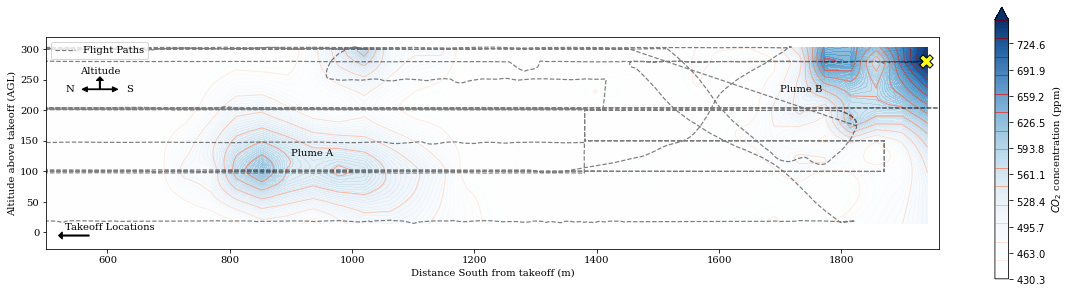

In [39]:
def add_alt_compass(ax) :
    
    x_unit = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.04
    y_unit = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.12
    center = [ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) *.06, 
             ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) *.25]
    
    ax.arrow(center[0], center[1], 0, y_unit/2, head_width=x_unit * 0.2, head_length=y_unit * 0.15, width=x_unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0], center[1], -x_unit/2, 0, head_width=y_unit * 0.2, head_length=x_unit * 0.15, width=y_unit * 0.03, length_includes_head=True, color='black')
    ax.arrow(center[0], center[1], x_unit/2, 0, head_width=y_unit * 0.2, head_length=x_unit * 0.15, width=y_unit * 0.03, length_includes_head=True, color='black')

    ax.annotate('Altitude', xy=(center[0], center[1] + y_unit/1.4), ha='center', va='center')
    ax.annotate('S', xy=(center[0] + x_unit/1.2, center[1]), ha='center', va='center')
    ax.annotate('N', xy=(center[0] - x_unit/1.2, center[1]), ha='center', va='center')
    
def add_takeoff_locations_arrow(ax):
    x_unit = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.04
    y_unit = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.12
    ax.annotate("Takeoff Locations", [530, 5])
    ax.arrow(570, -5, -50, 0, head_width=x_unit * 0.2, head_length=y_unit * 0.15, width=x_unit * 0.03, length_includes_head=True, color='black')
    
    
def display_altitude_distance_krig(name, starting_position, readings, all_data, nlags=6, minco2=None, maxco2=None, addons=None):
    fig, ax = plt.subplots(figsize=(20, 5))
    
    distance_data = []
    co2 = []
    altitude = []
    
    for i in range(len(readings)):
        d = readings[i]
        lat_diff = (starting_position.lat - d.lat) * (EARTH_CIRCUMFERENCE / 360)
        distance = lat_diff
        distance_data.append(distance)
        altitude.append(d.alt - starting_position.alt)
        co2.append(float(d.value))

    plot_krige(name, fig, ax, distance_data, altitude, co2, nlags, minco2, maxco2)
        
    path_distance = []
    path_alt = []
    for i in range(len(all_data)):
        d = all_data[i]
        lat_diff = (starting_position.lat - d.lat) * (EARTH_CIRCUMFERENCE / 360)
        distance = lat_diff
        path_distance.append(distance)
        path_alt.append(d.alt - starting_position.alt)
        co2.append(float(d.value))
    
    ax.plot(path_distance, path_alt, color='k', linestyle='--', lw=1.2, alpha=0.5, label="Flight Paths")

    if addons is not None:
        addons(plt, fig, ax)
    
    ax.legend(loc="upper left")
    
    ax.set_xlim(500, 1960)
    ax.set_aspect('equal')
    
    add_alt_compass(ax)
    
    add_takeoff_locations_arrow(ax)
    
    # Plumes
    ax.annotate("Plume A", [900, 125])
    ax.annotate("Plume B", [1700, 230])
    
    collection_point_distance = (starting_position.lat - collection_point.lat) * (EARTH_CIRCUMFERENCE / 360)
    
    ax.scatter(collection_point_distance, collection_point.alt - starting_position.alt, s=180, color='yellow', marker='X', zorder=2, edgecolors='black', linewidth=1)
    

    ax.set_xlabel('Distance South from takeoff (m)')
    ax.set_ylabel('Altitude above takeoff (AGL)')
    ax.plot()

minco2 = min([reading.value for reading in combined_data])
maxco2 = max([reading.value for reading in combined_data]) / 1.6

display_altitude_distance_krig('lapalma_combined2', lapalma_flight6[0], combined_data, all_data)

                               
saveFigure(plt, "altitude_krig")

2021-11-26 & 2 Plume A & 200 m & $2.33\times10^6$ & $2.07\times10^4$ & $3.89\times10^3$
2021-11-27 & 6 Plume A & 100 m & $1.40\times10^7$ & $4.25\times10^5$ & $2.33\times10^4$
2021-11-27 & 8 Plume A & 300 m & $3.18\times10^6$ & $2.77\times10^5$ & $5.30\times10^3$
2021-11-27 & 7 Plume B & 100 to 250 m & $4.64\times10^6$ & $1.96\times10^6$ & $7.74\times10^3$
2021-11-28 & 9 Plume B* & 300 m & $1.88\times10^7$ & $9.76\times10^6$ & $3.14\times10^4$


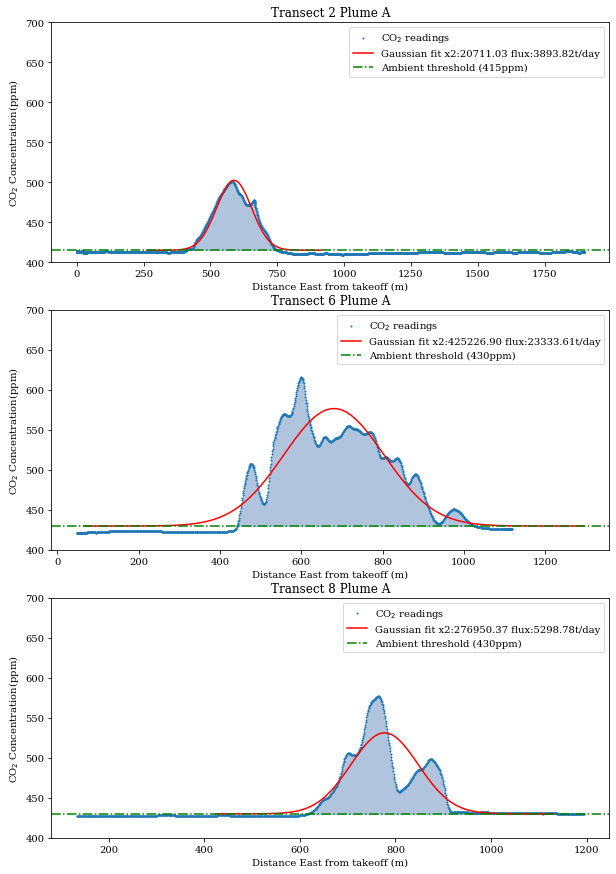

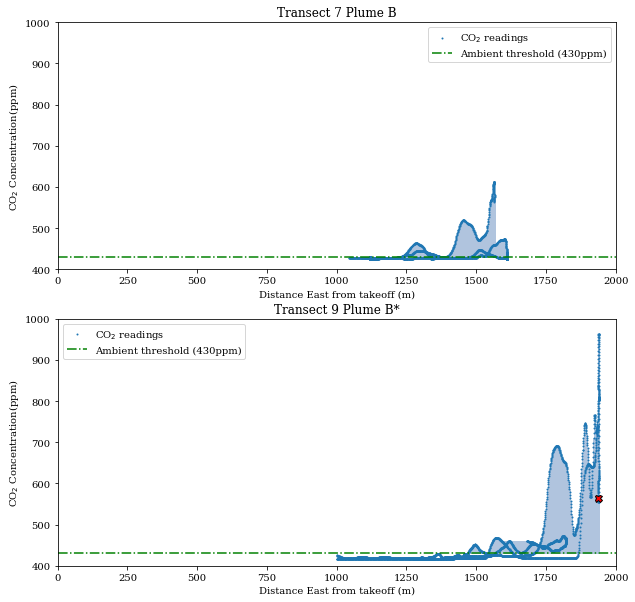

In [40]:
def add_collection_marker(ax):
    starting_position = lapalma_flight6[0]
    collection_point_distance = (starting_position.lat - collection_point.lat) * (EARTH_CIRCUMFERENCE / 360)
    
    ax.plot(collection_point_distance, collection_point.value, color='r', marker='X', zorder=2, markersize=7, markeredgecolor='black', markeredgewidth=1)
    
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

render_distance_data(lapalma_flight2a[0], lapalma_flight2a, 415, '2021-11-26', 2, 'A', 200, axs[0], legend=True)
render_distance_data(lapalma_flight5[0], first_plume, 430, '2021-11-27', 6, 'A', 100, axs[1], legend=True)
render_distance_data(lapalma_flight5[0], returning_plume, 430, '2021-11-27', 8, 'A', 300, axs[2], legend=True)
saveFigure(plt, "transect_plumeA")

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
render_distance_data(lapalma_flight5[0], curtain_plume, 430, '2021-11-27', 7, 'B', '100 to 250', axs[0], min_distance=1000, limit_distance=2000, legend=True, use_max=True, plot_gaussian=False, max_co2=1000)
render_distance_data(lapalma_flight6[0], lapalma_flight6, 430, '2021-11-28', 9, 'B*', 300, axs[1], min_distance=1000, limit_distance=2000, legend=True, use_max=True, plot_gaussian=False, max_co2=1000, delegate=add_collection_marker)

saveFigure(plt, "transect_plumeB")

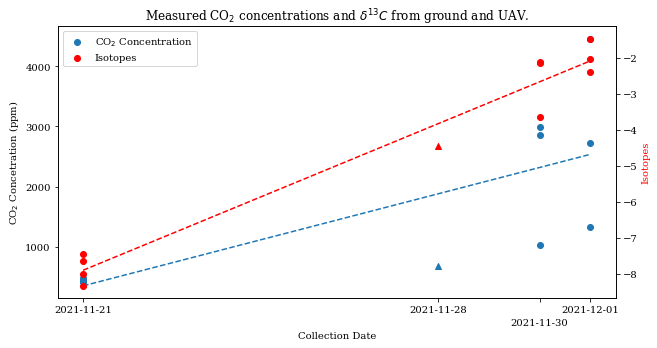

In [41]:
concentrations = [435.42, 471.54, 436.74, 416.00, 671.17, 1029.73, 2998.42, 2863.47, 4458.80, 2722.40, 1326.11]
isotopes = [-7.46, -8.34, -7.65, -8.00, -4.44, -3.65, -2.12, -2.15, -2.03, -1.47, -2.40]
date = ['2021-11-21', '2021-11-21', '2021-11-21', '2021-11-21', '2021-11-28', '2021-11-30', '2021-11-30', '2021-11-30', '2021-12-01', '2021-12-01', '2021-12-01']
unique_dates = list(set(date))
unique_dates.sort()
unique_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in unique_dates]
date = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in date]
ordinal_date = [d.toordinal() for d in date]
markers = 'o'
drone_marker = '^'

def arrayExcept(array, index):
    return array[:index] + array[index+1:]


fig, ax = plt.subplots(figsize=(10, 5))

ax2=ax.twinx()
ax.title.set_text("Measured CO$_2$ concentrations and $\delta^{13}C$ from ground and UAV.")
ax.scatter(arrayExcept(date, 4), arrayExcept(concentrations, 4), label="CO$_2$ Concentration", color='C0', marker=markers)
ax.scatter([date[4]], [concentrations[4]], color='C0', marker=drone_marker)
ax.scatter([], [], color="red", label="Isotopes", marker=markers) 
ax.set_ylabel("CO$_2$ Concetration (ppm)")


ax2.scatter(arrayExcept(date, 4), arrayExcept(isotopes, 4), color="red", marker=markers)
ax2.scatter([date[4]], [isotopes[4]], color="red", marker=drone_marker)
ax2.set_ylabel("Isotopes",color="red")

ax.legend()

ax.set_xlabel("Collection Date")

def linear_fit(x, y):
    z = np.polyfit(x, y, 1)
    return np.poly1d(z)

concentration_fit = linear_fit(ordinal_date, concentrations)
isotope_fit = linear_fit(ordinal_date, isotopes)

ax.plot(date, concentration_fit(ordinal_date), color='C0', linestyle='--')
ax.set_xticks(unique_dates)

labelx, labely = ax.get_xticklabels()[2].get_position()
ax.get_xticklabels()[2].set_position((labelx, labely - 0.05))

ax2.plot(date, isotope_fit(ordinal_date), 'r--')

saveFigure(plt, "table1")

In [42]:
# Isotope Data

def zero_intersect(one, two):
    x = one[0]
    y = one[1]
    m = (two[1] - one[1]) / (two[0] - one[0])
    b = -(m * x) + y
    return b

def argmin(values):
    min_index = 0
    minimum = values[min_index]
    for i in range(len(values)):
        if values[i] < minimum:
            min_index = i
            minimum = values[i]
    return min_index


CO2_ppm_reciprocal_ground = [0.0023, 0.0021, 0.0023, 0.00097, 0.00033, 0.00035, 0.00022, 0.00037, 0.00075]
delta13_C_per_thousand_ground = [-7.5, -8.3, -7.7, -3.7, -2.1, -2.2, -2, -1.5, -2.4 ]
lowest_ground_co2_index = argmin(CO2_ppm_reciprocal_ground)

CO2_ppm_reciprocal_drone = [0.0015]
delta13_C_per_thousand_drone = [-4.4]

CO2_ppm_reciprocal_ambient = [0.0024]
delta13_C_per_thousand_ambient = [-8]

bottom_intersect = zero_intersect([CO2_ppm_reciprocal_ambient[0], delta13_C_per_thousand_ambient[0]], [CO2_ppm_reciprocal_ground[lowest_ground_co2_index], delta13_C_per_thousand_ground[lowest_ground_co2_index]])
top_intersect = zero_intersect([CO2_ppm_reciprocal_ambient[0], delta13_C_per_thousand_ambient[0]], [CO2_ppm_reciprocal_drone[0], delta13_C_per_thousand_drone[0]])

La_Palma_cold_CO2_Gas = [-4.7, -2.8]
pyroxenes = [-2.5,-1.4]
El_Hierro_olivines = [-0.325, 1]
Tajogaite_Erupting_Gas = [bottom_intersect, top_intersect]

In [43]:
len(CO2_ppm_reciprocal_ground) == len(delta13_C_per_thousand_ground)

True

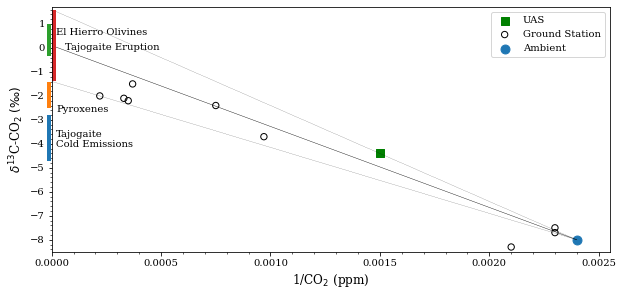

In [44]:
size = 80

fig, ax = plt.subplots(figsize=(10, 4.5))

# Line Plot from Ambient to Eruption
ax.plot([0, CO2_ppm_reciprocal_ambient[0]], [bottom_intersect, delta13_C_per_thousand_ambient[0]], "k--", linewidth=0.2)
ax.plot([0, CO2_ppm_reciprocal_ambient[0]], [top_intersect, delta13_C_per_thousand_ambient[0]], "k--", linewidth=0.2)
ax.plot([0, CO2_ppm_reciprocal_ambient[0]], [numpy.mean(Tajogaite_Erupting_Gas), delta13_C_per_thousand_ambient[0]], "k-", linewidth=0.4)

# Plot drone measurements
ax.scatter(CO2_ppm_reciprocal_drone, delta13_C_per_thousand_drone, s=size, marker='s', color='green', label='UAS')

# Plot ground measurements
ax.scatter(CO2_ppm_reciprocal_ground, delta13_C_per_thousand_ground, s=size/2, marker='o', edgecolors='black', facecolors='none', label='Ground Station')

# Plot ambient
ax.scatter(CO2_ppm_reciprocal_ambient, delta13_C_per_thousand_ambient, s=size, label='Ambient')

# Plot La Palma Cold Emmisions Range
ax.errorbar(-0.00001, numpy.mean(La_Palma_cold_CO2_Gas), yerr = numpy.diff(La_Palma_cold_CO2_Gas)/2, fmt ='', linewidth=4, clip_on=False)
ax.text(0.00002, numpy.mean(La_Palma_cold_CO2_Gas)-0.4, 'Tajogaite\nCold Emissions')

# Plot Pyroxenes Range
ax.errorbar(-0.00001, numpy.mean(pyroxenes), yerr = numpy.diff(pyroxenes)/2, fmt ='', linewidth=4, clip_on=False)
ax.text(0.00002, numpy.mean(pyroxenes)-0.7, 'Pyroxenes')

# Plot El Hierro Olivines
ax.errorbar(-0.00001, numpy.mean(El_Hierro_olivines), yerr = numpy.diff(El_Hierro_olivines)/2, fmt ='', linewidth=4, clip_on=False)
ax.text(0.00002, numpy.mean(El_Hierro_olivines)+0.2, 'El Hierro Olivines')

# Plot La Palma Eruption Emmisions Range
ax.errorbar(0.00001, numpy.mean(Tajogaite_Erupting_Gas), yerr = numpy.diff(Tajogaite_Erupting_Gas)/2, fmt ='', linewidth=4, clip_on=False)
ax.text(0.00006, numpy.mean(Tajogaite_Erupting_Gas)-0.2, 'Tajogaite Eruption')

ax.set_xlabel(r'1/CO$_2$ (ppm)', size=12)
ax.set_ylabel(r'$\delta^{13}$C-CO$_2 \; (\perthousand)$', size=12) 
ax.set_ylim(-8.5,1.7)
ax.set_xlim(0, 0.00255)
ax.set_yticks(range(-8,2))
ax.minorticks_on()
ax.legend() 

saveFigure(plt, "KeelingPlot")

2021-11-26 & 2 Plume A & 200 m & $2.33\times10^6$ & $2.07\times10^4$ & $3.89\times10^3$
2021-11-27 & 6 Plume A & 100 m & $1.40\times10^7$ & $4.25\times10^5$ & $2.33\times10^4$
2021-11-27 & 8 Plume A & 300 m & $3.18\times10^6$ & $2.77\times10^5$ & $5.30\times10^3$
2021-11-27 & 7 Plume B & 100 to 250 m & $4.64\times10^6$ & $1.96\times10^6$ & $7.74\times10^3$
2021-11-28 & 9 Plume B* & 300 m & $6.50\times10^7$ & $1.81\times10^7$ & $1.08\times10^5$


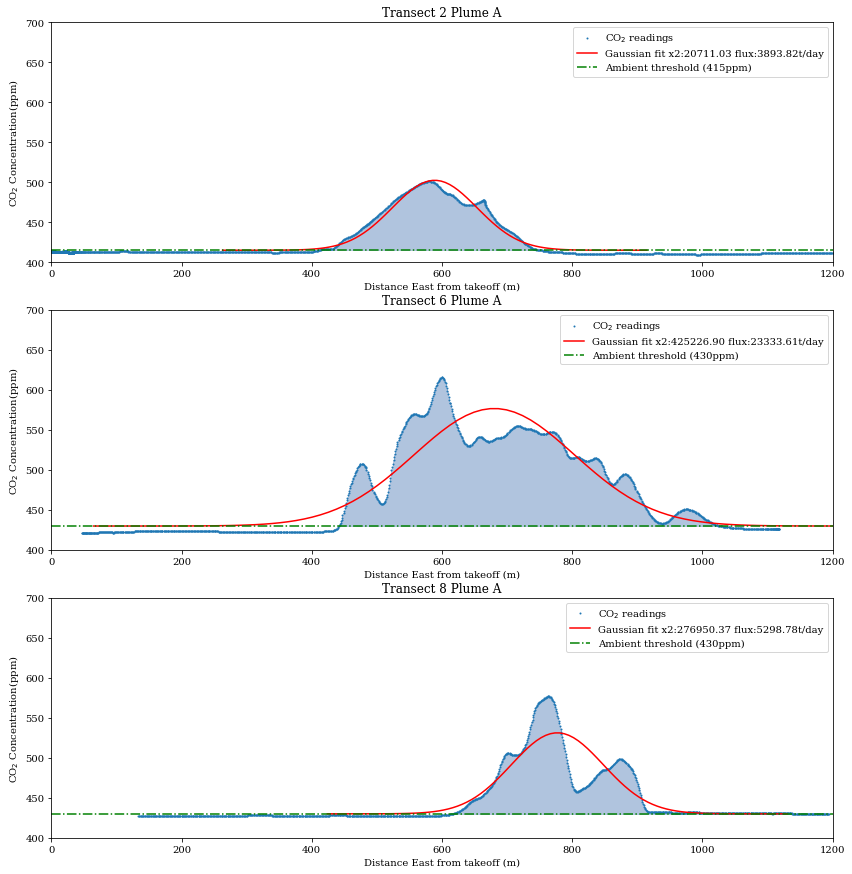

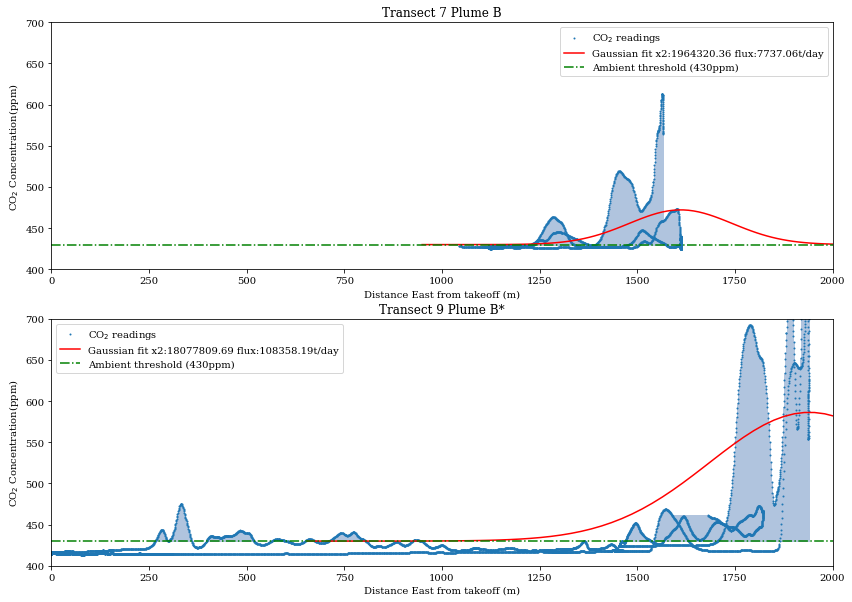

In [45]:
fig, axs = plt.subplots(3, 1, figsize=(14, 15))

render_distance_data(lapalma_flight2a[0], lapalma_flight2a, 415, '2021-11-26', 2, 'A', 200, axs[0], limit_distance=1200, legend=True)
render_distance_data(lapalma_flight5[0], first_plume, 430, '2021-11-27', 6, 'A', 100, axs[1], limit_distance=1200, legend=True)
render_distance_data(lapalma_flight5[0], returning_plume, 430, '2021-11-27', 8, 'A', 300, axs[2], limit_distance=1200, legend=True)

fig, axs = plt.subplots(2, 1, figsize=(14, 10))

render_distance_data(lapalma_flight5[0], curtain_plume, 430, '2021-11-27', 7, 'B', '100 to 250', axs[0], limit_distance=2000, legend=True, use_max=True)
render_distance_data(lapalma_flight6[0], lapalma_flight6, 430, '2021-11-28', 9, 'B*', 300, axs[1], limit_distance=2000, legend=True, use_max=True)

In [ ]:
  
fig, axs = plt.subplots(6, 2, figsize=(16, 40))

render_distance_data(lapalma_flight1[0], lapalma_flight1, 419, '2021-11-26', 1, 'A', 200, axs[0,0], legend=True, use_max=True)
render_distance_data(lapalma_flight2a[0], lapalma_flight2a, 415, '2021-11-26', 2, 'A', 200, axs[0,1], legend=True)
# render_distance_data(lapalma_flight2a[0], (lapalma_flight2a + lapalma_flight2b), 415, 'Flight 2 Transect 2+3, A', axs[1,1], legend=True)
render_distance_data(lapalma_flight2b[len(lapalma_flight2b) - 1], lapalma_flight2b, 415, '2021-11-26', 3, 'A', 200, axs[1,0], legend=True)
render_distance_data(lapalma_flight3[0], lapalma_flight3, 420, '2021-11-26', 4, 'A', 200, axs[2,0], legend=True)
render_distance_data(lapalma_flight4[0], lapalma_flight4, 424, '2021-11-27', 5, 'A', 300, axs[2,1], legend=True)
# render_distance_data(lapalma_flight5[0], lapalma_flight5, 430, 'Flight 5 Transect 6 + 7 + 8, A+B',  axs[3,0], legend=True)
render_distance_data(lapalma_flight5[0], first_plume, 430, '2021-11-27', 6, 'A', 100, axs[3,1], legend=True)
render_distance_data(lapalma_flight5[0], curtain_plume, 430, '2021-11-27', 7, 'B', '100 to 250', axs[4,0], legend=True, use_max=True)
render_distance_data(lapalma_flight5[0], returning_plume, 430, '2021-11-27', 8, 'A', 300, axs[4,1], legend=True)
render_distance_data(lapalma_flight6[0], lapalma_flight6, 430, '2021-11-28', 9, 'B*', 300, axs[5,0], legend=True, use_max=True)
render_distance_data(lapalma_flight8[0], lapalma_flight8, 418, '2021-11-29', 10, 'A', 300, axs[5,1], legend=True, use_max=True)

saveFigure(plt, "transects")

2021-11-26 & 1 Plume A & 200 m & $1.97\times10^6$ & $3.08\times10^4$ & $3.29\times10^3$
2021-11-26 & 2 Plume A & 200 m & $2.33\times10^6$ & $2.07\times10^4$ & $3.89\times10^3$
2021-11-26 & 3 Plume A & 200 m & $1.29\times10^6$ & $1.06\times10^4$ & $2.15\times10^3$
2021-11-26 & 4 Plume A & 200 m & $7.58\times10^5$ & $7.37\times10^2$ & $1.26\times10^3$
2021-11-27 & 5 Plume A & 300 m & $1.91\times10^6$ & $6.25\times10^4$ & $3.19\times10^3$
2021-11-27 & 6 Plume A & 100 m & $1.40\times10^7$ & $4.25\times10^5$ & $2.33\times10^4$
2021-11-27 & 7 Plume B & 100 to 250 m & $4.64\times10^6$ & $1.96\times10^6$ & $7.74\times10^3$
2021-11-27 & 8 Plume A & 300 m & $3.18\times10^6$ & $2.77\times10^5$ & $5.30\times10^3$
2021-11-28 & 9 Plume B* & 300 m & $6.50\times10^7$ & $1.81\times10^7$ & $1.08\times10^5$
2021-11-29 & 10 Plume A & 300 m & $2.98\times10^5$ & $1.42\times10^5$ & $4.96\times10^2$


In [ ]:
def display_scatter_on_map(readings, title, ax, draw_path=False):
    lat_1 = min([r.lat for r in readings])
    lat_2 = max([r.lat for r in readings])
    lon_1 = min([r.lon for r in readings])
    lon_2 = max([r.lon for r in readings])
    
    plot_scatter(fig, ax, readings, draw_path)

    show(la_palma_map.read(), ax=ax, transform=la_palma_map_original.transform)
    
    zoom_to_data(ax, readings)
    geo_axis_format(ax)
    ax.title.set_text(title)

    ax.plot()

fig, axs = plt.subplots(4, 2, figsize=(16, 20))

display_scatter_on_map(lapalma_flight1, 'Flight 1 Transect 1 Plume A', axs[0,0])
display_scatter_on_map(lapalma_flight2a, 'Flight 2 Transect 2 Plume A', axs[0,1])
display_scatter_on_map(lapalma_flight2b, 'Flight 2 Transect 3 Plume A', axs[1,0])
display_scatter_on_map(first_plume, 'Flight 5 Transect 6 Plume A', axs[1, 1])
display_scatter_on_map(curtain_plume, 'Flight 5 Transect 7 Plume B', axs[2,0])
display_scatter_on_map(returning_plume, 'Flight 5 Transect 8 Plume A', axs[2,1])
display_scatter_on_map(lapalma_flight6, 'Flight 6 Transect 9 Plume B', axs[3,0])
display_scatter_on_map(lapalma_flight8, 'Flight 8 Transect 10 Plume A', axs[3,1])

saveFigure(plt, "transects_map")